# Unstable Approach
Define a flight is stable or unstable based on determined parameters.

### Import

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import pandas as pd
import seaborn as sns
import os

### Constant

In [3]:
base_path = '../dataset/database_local'
# base_path = '../dataset/database'

In [4]:
flight_runway_file = base_path + '/04_flights_with_runway.csv'
landing_runway_file = base_path + '/04_landing_count_detail.csv'
output_file = base_path + '/06_all_crucial_fdm.csv'

### Read Data

#### 1. Read Flight Runway Data 

In [5]:
flight_runway = pd.read_csv(flight_runway_file)
flight_runway.head()

,fname,tail_id,dep_airport,dep_rwy,arr_airport,arr_rwy,fsize_mb,fullpath
0,686200104121532.csv,tail_686_1,BHM,36,DTW,09R,68.39,../dataset/fdm/tail_686_1/686200104121532.csv
1,686200104121245.csv,tail_686_1,DTW,03L,BHM,24,61.52,../dataset/fdm/tail_686_1/686200104121245.csv
2,686200104121825.csv,tail_686_2,DTW,03L,LEX,22,40.71,../dataset/fdm/tail_686_2/686200104121825.csv
3,686200104130429.csv,tail_686_2,LEX,22,DTW,09R,42.63,../dataset/fdm/tail_686_2/686200104130429.csv
4,686200104130652.csv,tail_687_1,DTW,09R,OKC,31,95.92,../dataset/fdm/tail_687_1/686200104130652.csv


#### 2. Read Landing Runway Count

In [6]:
landing_runway_count = pd.read_csv(landing_runway_file)
landing_runway_count.head()

,iata_code,runway_ident,flight_count,icao_code,type,name,latitude_rad,longitude_rad,elevation_ft,scheduled_service
0,DTW,DTW.09R,2,KDTW,large_airport,Detroit Metropolitan Wayne County Airport,0.736745,-1.454791,645.0,yes
1,LEX,LEX.22,1,KLEX,large_airport,Blue Grass Airport,0.663862,-1.476652,979.0,yes
2,BHM,BHM.24,1,KBHM,large_airport,Birmingham-Shuttlesworth International Airport,0.585783,-1.514134,650.0,yes
3,OKC,OKC.31,1,KOKC,large_airport,Will Rogers World Airport,0.617726,-1.703454,1295.0,yes


## Data Exploration

In [7]:
df = pd.read_csv(flight_runway.fullpath[0])

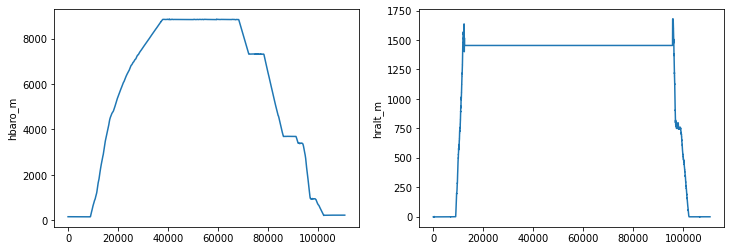

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
sns.lineplot(data = df.hbaro_m, ax=ax1)
sns.lineplot(data = df.hralt_m, ax=ax2)
plt.show()

### Data Transformation

##### Get Crucial DF
Crucial DataFrame is the landaing data started from when altitude equals `alt_m` with the duration of `duration_s`  

In [9]:
sampling_rate = 16

In [10]:
# Change to hralt_m
# 1000 >= alt >= 500
def get_crucial_df(df_fdm, alt_m, duration_s, sampling_rate=16):
    idx_max = np.where(df_fdm['hbaro_m'].eq(max(df_fdm['hbaro_m'])), df_fdm.index, 0).max()+1
    landing_df = df_fdm.loc[idx_max:]
    crucial_alt_start_idx = landing_df[landing_df['hbaro_m'] <= alt_m].index[0]
    crucial_df = landing_df.loc[crucial_alt_start_idx:].iloc[:duration_s*sampling_rate]
    # sns.lineplot(data = crucial_df.hbaro_m)`
    return crucial_df

In [11]:
cols = ['flap_te_pos', 'hbaro_m', 'hralt_m', 'hdot_1_mps', 'gs_mps', \
        'gs_dev_ddm', 'loc_dev_ddm', 'n11_rpm', 'n12_rpm', 'n13_rpm', \
        'n14_rpm', 'tas_mps', 'theta_rad', 'chi_rad', 'lg_squat_mr']

In [12]:
def get_crucial_df_from_file(filepath, cols=cols):
    df_fdm = pd.read_csv(filepath, usecols=cols)
    crucial_df = get_crucial_df(df_fdm, 1000, 10)
    crucial_df['file'] = os.path.basename(filepath)
    return crucial_df

<AxesSubplot:ylabel='hralt_m'>

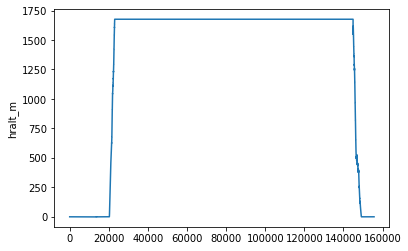

In [13]:
test_df = pd.read_csv(flight_runway.fullpath[4])
sns.lineplot(data=test_df.hralt_m)

In [14]:
all_df = pd.DataFrame()
file = open(output_file, "w")
file.close()
with open(output_file, 'a') as f:
    for file in flight_runway.fullpath[:8]:
        df = get_crucial_df_from_file(file, cols)
        df.to_csv(f, mode='a', header=f.tell()==0)
        all_df = all_df.append(df)

In [16]:
import defs

In [17]:
# Multiprocessing
if __name__ == '__main__':
    params = flight_runway.fullpath.tolist()
    p = mp.Pool(10)

    all_df = pd.DataFrame()
    file = open(output_file, "w")
    file.close()
    with open(output_file, 'a') as f:
        for i, result in enumerate(p.imap_unordered(defs.get_crucial_df_from_file, params)):
            result.to_csv(f, mode='a', header=f.tell()==0)
            all_df = all_df.append(result)
            print(f"Done: {i+1}/{len(params)}")

Done: 1/5
Done: 2/5
Done: 3/5
Done: 4/5
Done: 5/5


In [18]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 56812 to 146351
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   hbaro_m      200 non-null    float64
 1   hdot_1_mps   200 non-null    float64
 2   flap_te_pos  50 non-null     float64
 3   gs_dev_ddm   50 non-null     float64
 4   gs_mps       200 non-null    float64
 5   loc_dev_ddm  50 non-null     float64
 6   lg_squat_mr  100 non-null    float64
 7   n11_rpm      200 non-null    float64
 8   n12_rpm      200 non-null    float64
 9   n13_rpm      200 non-null    float64
 10  n14_rpm      200 non-null    float64
 11  theta_rad    400 non-null    float64
 12  hralt_m      400 non-null    float64
 13  tas_mps      200 non-null    float64
 14  chi_rad      200 non-null    float64
 15  file         800 non-null    object 
dtypes: float64(15), object(1)
memory usage: 106.2+ KB


In [23]:
all_df.to_csv(base_path + '/06_all_crucial_fdm_backup.csv')